In [2]:
import matplotlib.pylab as plt
import tensorflow as tf
import scipy.io as io
import tensorflow_hub as hub
from tensorflow.keras import layers
import pandas as pd
import PIL.Image as Image
import numpy as np

In [3]:
tf.enable_eager_execution()
classifier_url ="https://tfhub.dev/google/tf2-preview/mobilenet_v2/classification/2" #@param {type:"string"}
labels_path = tf.keras.utils.get_file('ImageNetLabels.txt','https://storage.googleapis.com/download.tensorflow.org/data/ImageNetLabels.txt')
imagenet_labels = np.array(open(labels_path).read().splitlines())

In [4]:
img_lists = io.loadmat('Lists/English/Img/lists.mat')['list']
training_indices = img_lists['TRNind'][0][0][:, -1]
all_labels = img_lists['ALLlabels'][0][0][:, -1]
all_names = img_lists['ALLnames'][0][0]


In [5]:
labels = all_labels[training_indices - 1]

Found 930 images belonging to 62 classes.
Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 62)
(32, 1001)


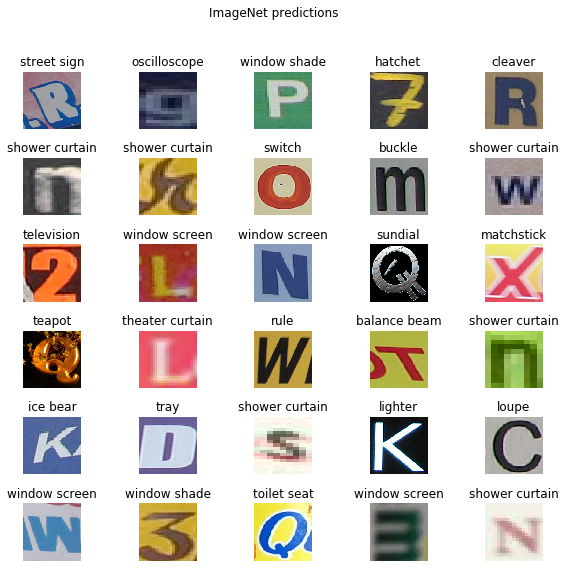

In [6]:
IMAGE_SHAPE = (224, 224)
classifier = tf.keras.Sequential([
    hub.KerasLayer(classifier_url, input_shape=IMAGE_SHAPE+(3,))
])

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory("TrainSet", target_size=IMAGE_SHAPE)

for image_batch, label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

result_batch = classifier.predict(image_batch)
print(result_batch.shape)

predicted_class_names = imagenet_labels[np.argmax(result_batch, axis=-1)]

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(predicted_class_names[n])
  plt.axis('off')
_ = plt.suptitle("ImageNet predictions")

plt.show()

In [7]:
feature_extractor_url = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/2" #@param {type:"string"}
feature_extractor_layer = hub.KerasLayer(feature_extractor_url,
                                         input_shape=(224,224,3))
feature_batch = feature_extractor_layer(image_batch)
print(feature_batch.shape)
feature_extractor_layer.trainable = False
model = tf.keras.Sequential([
  feature_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])


(32, 1280)


In [8]:
model.summary()
predictions = model(image_batch)
model.compile(
  optimizer=tf.keras.optimizers.Adam(),
  loss='categorical_crossentropy',
  metrics=['acc'])

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []

  def on_train_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])
    self.model.reset_metrics()

steps_per_epoch = np.ceil(image_data.samples/image_data.batch_size)

batch_stats_callback = CollectBatchStats()

history = model.fit_generator(image_data, epochs=15,
                              steps_per_epoch=steps_per_epoch,
                              callbacks = [batch_stats_callback])


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 1280)              2257984   
_________________________________________________________________
dense (Dense)                (None, 62)                79422     
Total params: 2,337,406
Trainable params: 79,422
Non-trainable params: 2,257,984
_________________________________________________________________
Epoch 1/15
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


30/30 [==============================] - 21s 717ms/step - loss: 4.3527 - acc: 0.0312
Epoch 2/15
30/30 [==============================] - 17s 578ms/step - loss: 2.9348 - acc: 0.2188
Epoch 3/15
30/30 [==============================] - 18s 584ms/step - loss: 2.2660 - acc: 0.4688
Epoch 4/15
30/30 [==============================] - 20s 682ms/step - loss: 1.7415 - acc: 0.5625
Epoch 5/15
30/30 [==============================] - 17s 580ms/step - loss: 1.4968 - acc: 0.8125
Epoch 6/15
30/30 [==============================] - 18s 585ms/step - loss: 1.2340 - acc: 0.9062
Epoch 7/15
30/30 [==============================] - 18s 584ms/step - loss: 1.0562 - acc: 0.9062
Epoch 8/15
30/30 [==============================] - 18s 603ms/step - loss: 0.9129 - acc: 0.9062
Epoch 9/15
30/30 [==============================] - 18s 586ms/step - loss: 0.7799 - acc: 0.9062
Epoch 10/15
30/30 [==============================] - 19s 629ms/step - loss: 0.6893 - acc: 0.9375
Epoch 11/15
30/30 [==============================]

In [21]:
def label_to_class(label):
    index = int(label[1:-1])
    
    if(index <= 10):
        return str(index - 1)
    if(index <= 37):
        return str(chr(ord('A') + index - 11))
    
    return str(chr(ord('a') + index - 37))
    

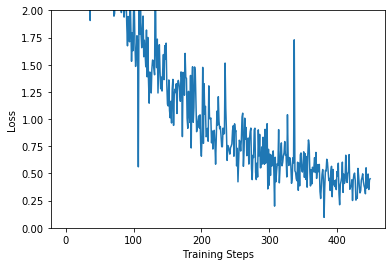

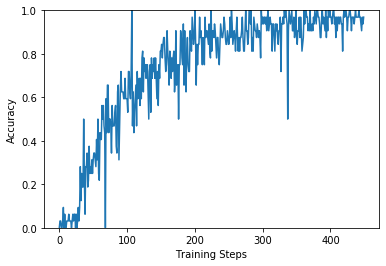

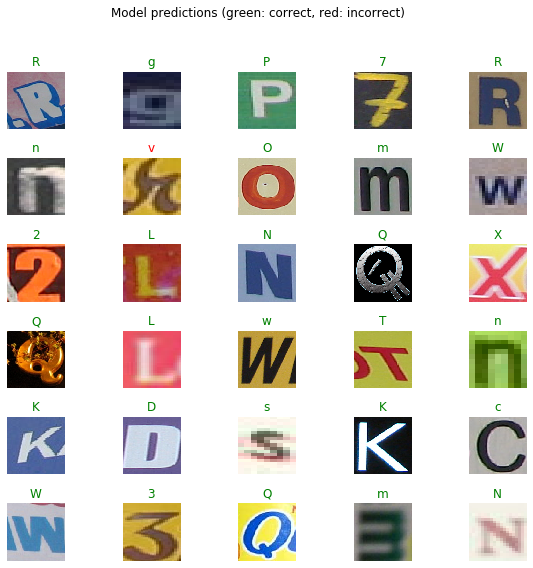

In [22]:
plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats_callback.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats_callback.batch_acc)

class_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
class_names = np.array([key.title() for key, value in class_names])
class_names
predicted_batch = model.predict(image_batch)
predicted_id = np.argmax(predicted_batch, axis=-1)
predicted_label_batch = class_names[predicted_id]
label_id = np.argmax(label_batch, axis=-1)

plt.figure(figsize=(10,9))
plt.subplots_adjust(hspace=0.5)
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  color = "green" if predicted_id[n] == label_id[n] else "red"
  plt.title(label_to_class(predicted_label_batch[n].title()), color=color)
  plt.axis('off')
_ = plt.suptitle("Model predictions (green: correct, red: incorrect)")